In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from models import glow
from flows.glow import coupling_nn_glow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Input, Concatenate
from tensorflow.keras import Model

#tf.config.experimental_run_functions_eagerly(True)

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
batch_size = 100
X_train = np.expand_dims(X_train, axis=-1)
X_train_ds = tf.data.Dataset.from_tensor_slices(X_train.astype(np.float32))
X_train_ds = X_train_ds.map(lambda x: x / 255. - 0.5).shuffle(buffer_size=1000).batch(batch_size)

In [3]:
prior_dist = tfp.distributions.Normal(loc=tf.zeros((1, *X_train.shape[1:])),
                                      scale=tf.ones((1, *X_train.shape[1:])))
def prior_model(input_shape):
    from tensorflow.keras.regularizers import l2
    x = Input(input_shape)
    y = Conv2D(32, 5, activation='relu', padding='same', kernel_regularizer=l2(1.0E-4))(x)
    y = Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(1.0E-4))(y)
    theta = Conv2D(2, 3, activation='linear', padding='same', kernel_regularizer=l2(1.0E-4))(y)
    return Model(inputs=x, outputs=theta)

def logistic(bijector=tfp.bijectors.Identity(), axis=-1, epsilon=1.0E-6):
    def _logistic(params: tf.Tensor):
        mus = tf.gather(params, [0], axis=axis)
        log_scales = tf.gather(params, [1], axis=axis)
        base_dist = tfp.distributions.Logistic(loc=mus, scale=epsilon + tf.math.exp(log_scales), allow_nan_stats=False)
        transformed_dist = tfp.distributions.TransformedDistribution(base_dist, bijector=bijector)
        return transformed_dist
    return _logistic

def normal(bijector=tfp.bijectors.Identity(), axis=-1, epsilon=1.0E-6):
    def _normal(params: tf.Tensor):
        mus = tf.gather(params, [0], axis=axis)
        log_sigmas = tf.gather(params, [1], axis=axis)
        shape = tf.shape(mus)
        mus = tf.reshape(mus, (-1, tf.math.reduce_prod(shape[1:])))
        log_sigmas = tf.reshape(log_sigmas, (-1, tf.math.reduce_prod(shape[1:])))
        base_dist = tfp.distributions.MultivariateNormalDiag(loc=mus, scale_diag=epsilon + tf.math.exp(log_sigmas), allow_nan_stats=False)
        reshape = tfp.bijectors.Reshape(shape[1:])
        chain = tfp.bijectors.Chain([bijector, reshape])
        transformed_dist = tfp.distributions.TransformedDistribution(base_dist, bijector=chain)
        return transformed_dist
    return _normal

In [4]:
##### from models.optimization import LinearWarmupSchedule
# adamax with 100,000 linearly annealed warmup steps
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
model = glow.Glow(prior_dist, num_layers=3, depth_per_layer=32, num_bins=255,
                  optimizer=optimizer, coupling_nn_ctor=coupling_nn_glow(hidden_dims=32))

In [5]:
model.train(X_train_ds, X_train.shape[0] // batch_size, num_epochs=20)

  7%|▋         | 833/12000 [20:05<4:29:26,  1.45s/it, epoch=2, loss=36.5, nll=36.4, prior=1.09, ildj=-1.46e+4]


KeyboardInterrupt: 

In [6]:
x = X_train[[i for i in np.random.randint(0, X_train.shape[0], size=6)]].astype(np.float32) / 255. - 0.5
t = model.prior(x)
dist = model.prior_parameterize(t)

TypeError: 'Normal' object is not callable

In [7]:
z = tf.reshape(prior_dist.sample(6), (6, *X_train.shape[1:]))
#z = dist.sample()
x_, _= model.glow.inverse(z)
_ = tf.debugging.assert_all_finite(x_, 'inverse produced nan/inf values')

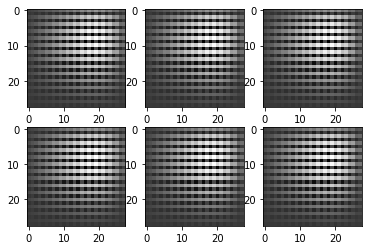

In [8]:
import matplotlib.pyplot as plt
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.squeeze(x_[i]), cmap='gray')
plt.show()